In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import lightkurve as lk
from astropy.timeseries import LombScargle

def get_targets(obs_dates):
    names = []
    for obs_date in obs_dates:
        files = glob.glob("/alps/south/reduced/%s_analyzed/movies/*/*" % (obs_date))
        for file in files:
            name = file.split("/")[-2]
            names.append(name)
    names = sorted(list(set(names)))
    return names
def show_periodogram_and_lc(time, flux, flux_raw, minimum_period=1, maximum_period=100, bin_dt=5):
    poly = np.polyfit(time,flux, deg=3)
    y_red = np.polyval(poly, time)
    flux_normalized = flux/y_red
    
    lc = lk.LightCurve(data=None, time=time, flux=  flux_normalized, flux_err=None)
    lc = lc.remove_outliers()
    lc_raw = lk.LightCurve(data=None, time=time, flux=  flux_raw, flux_err=None)
    lc_raw = lc_raw.remove_outliers()    
    pg = lc.to_periodogram(minimum_period=minimum_period, maximum_period=maximum_period)
    period = pg.period_at_max_power
    period_now = period.value
    pg.plot(view='period') ;
    plt.xscale("log")
    plt.show()
    
    ls = LombScargle(lc.time, lc.flux, np.std( lc.flux)) 
    freq, power = ls.autopower()
    fap = ls.false_alarm_probability(power)
    #fap = ls.false_alarm_probability(power, method='bootstrap')
    plt.plot(1/freq, fap)
    plt.xlim(minimum_period, maximum_period)
    plt.xlabel("period [sec]")
    plt.ylabel("FAP")
    plt.xscale("log")
    plt.yscale("log")
    plt.show()
    
    
    lc_bin = lc.bin(bin_dt)
    fig=plt.figure(figsize = (14, 7))
    plt.plot(lc_raw.time.value, lc_raw.flux/np.median(lc_raw.flux), label="raw")
    #plt.plot(lc.time.value, lc.flux.value, label = "pca 1s")
    plt.plot(lc_bin.time.value, lc_bin.flux.value,label ="pca %ds" % bin_dt)
    plt.xlabel("Time [s]", fontsize  = 23)
    plt.ylabel("flux", fontsize  = 23)
    plt.legend(fontsize = 15)
    #plt.ylim(0.97, 1.03)
    plt.show()
    return pg, lc, period_now
    
bin_dt= 20
r_ap = 25## choose from 10, 15, 20, 25
n_comp_sub = 4
obs_dates= ["20211014", "20211015", "20220111", "20220112"]#, "20220113", "20220114", "20220524"]
targets = get_targets(obs_dates)
print(targets)
#band =  ## g_band, r_band, z_band


['IRAS00500+6713', 'WD_new0', 'WD_new13', 'WD_new15', 'WD_new16', 'WD_new21', 'WD_new22', 'WD_new24', 'WD_new25', 'WD_new29', 'WD_new30', 'WD_new31', 'WD_triccs12', 'WD_triccs18', 'WD_triccs22', 'WD_triccs23', 'WD_triccs24', 'WD_triccs25', 'WD_triccs26', 'WD_triccs28', 'WD_triccs29', 'WD_triccs30', 'WD_triccs31', 'ZTFJ1901+1458']


In [3]:
len(targets)

24

20211014
20211015
20220111
/alps/south/reduced/20220111_analyzed/movies/WD_triccs18/g_band/target_processed_898348313253395968_lc25.npz
898348313253395968


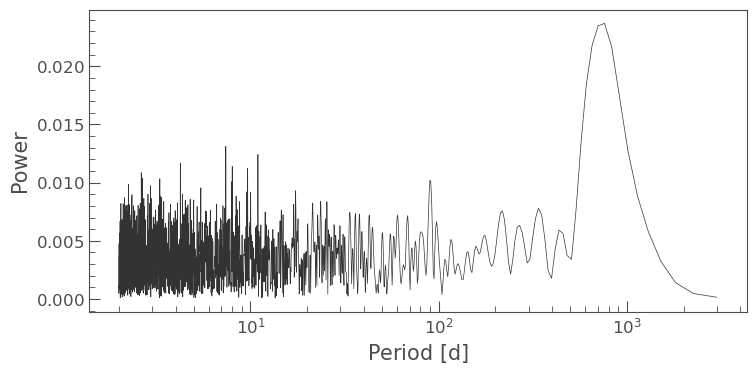

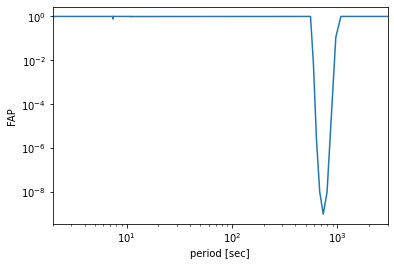

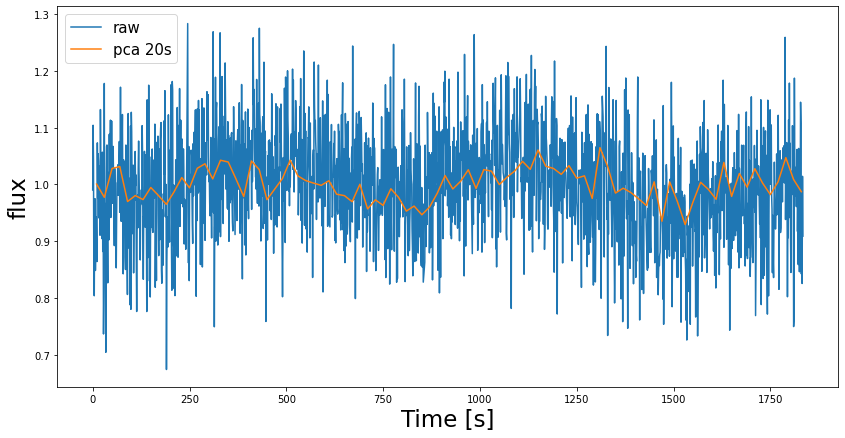

760.5989409080831


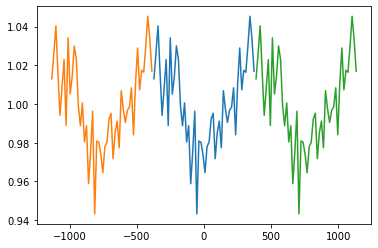

<ipython-input-94-d114c1a378d0>:34: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(np.sum(movie, axis=0)))


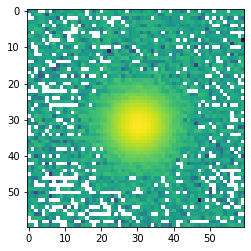

20220112


In [94]:
name  = "WD_triccs18"
data_arr =[]
band =  "g_band" #g_band, r_band, z_band
for obs_date in obs_dates:
    out_dir = "/alps/south/reduced/%s_analyzed/movies/%s/%s" % (obs_date, name,  band)
    files = sorted(glob.glob(out_dir + "/target_processed_*_lc%d.npz" % r_ap))
    raw_files = sorted(glob.glob(out_dir + "/target_and_others_*_lc%d.npz" % r_ap))
    print(obs_date)
    for (i, file) in enumerate(files):
        print(file)
        gaia_id= file.split("_")[-2]
        print(gaia_id)
        data = np.load(file)
        data_raw = np.load(raw_files[i])
        time_target = data["time"]- np.min(data["time"])
        mask = time_target>-1# >400#300#<1400##<1500
        flux_target_pca = data["lc_pca"][n_comp_sub-1]
        flux_least = data["lc_least_var"]
        flux_target_raw = data_raw["flux_target"]
        pg, lc, period_now = show_periodogram_and_lc(time_target[ mask ], flux_target_pca[ mask ], flux_target_raw[ mask ] , maximum_period=3000, minimum_period=2, bin_dt = bin_dt )  
        #show_periodogram_and_lc(time_target - np.min(time_target), flux_least, flux_target_raw , maximum_period=5000, minimum_period=2, bin_dt = bin_dt )  
        #period_now = 634
        lc_fold = lc.fold(period=period_now)
        lc_fold.flux = lc_fold.flux /np.median(lc_fold.flux )
        lc_bin = lc_fold.bin(period_now /50)
        print(period_now)
        plt.plot(lc_bin.time.value, lc_bin.flux.value)
        plt.plot(lc_bin.time.value -period_now, lc_bin.flux.value)
        plt.plot(lc_bin.time.value +period_now, lc_bin.flux.value)
        plt.show()        
        
        d_movie = np.load(out_dir + "/movie_after_bkgsub_%s.npz" % gaia_id)
        movie= d_movie["movie"]
        plt.imshow(np.log10(np.sum(movie, axis=0)))
        plt.show()
        
        

In [114]:
def make_aperture(wd = 60, aperture_size = 20):
    wd_all = 2 * wd
    x = np.linspace(0, wd_all  -1,wd_all  )
    y = np.linspace(0, wd_all -1, wd_all )
    x -= np.mean(x)
    y -= np.mean(y)
    xx, yy = np.meshgrid(x, y)
    r =( xx**2 + yy**2)**0.5
    r_ap = r<aperture_size
    return r_ap
def compute_centroids(movies , r_ap_size = 15):
    nt, nx, ny = np.shape(movie)
    r_ap = make_aperture(int(nx/2), r_ap_size )
    x_coord = np.arange(nx).astype(float)
    y_coord = np.arange(nx).astype(float)
    x_coord -= np.mean(x_coord)
    y_coord -= np.mean(y_coord)
    xx, yy = np.meshgrid(x_coord, y_coord)
    x_flux = movie * xx * r_ap
    y_flux = movie * yy * r_ap
    x_flux_sum = np.sum(x_flux, axis=(1,2))
    y_flux_sum = np.sum(y_flux, axis=(1,2))
    flux_sum = np.sum(movie * r_ap, axis=(1,2))
    x_cen = x_flux_sum/flux_sum
    y_cen = y_flux_sum/flux_sum
    
    return x_cen, y_cen

In [117]:
x_cen, y_cen = compute_centroids(movie, 20)

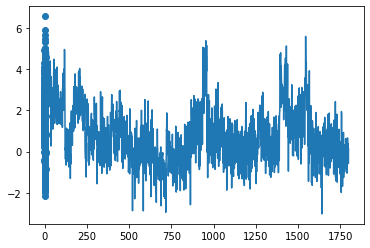

In [118]:
plt.scatter(x_cen, y_cen)
plt.plot(x_cen)

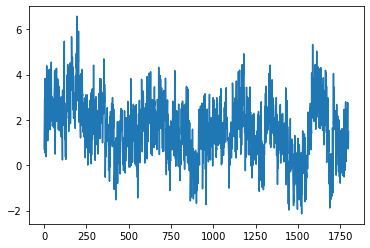

In [119]:
plt.plot(y_cen)